# Predicting the Section of a Guardian Article <a class="anchor" id="top"></a>

**Simon Hall**

The aim of this project is to perform a systematic investigation of a number of Deep Learning methods in the context of text processing, and text classification. This task uses a dataset of articles extracted from *The Guardian* newspaper, and aims to predict the broader section from which an article was taken.

## Contents:
* [1. Importation & Description](#import-bullet)
* [2. Pre-Processing](#pre-bullet)
    * [i. Feature Reduction](#a-bullet)
    * [ii. Number of Labels and Data Quality](#b-bullet)
    * [iii. Remove Stop Words and Lemmatisation](#c-bullet)
    * [iv. Target Variable Extraction](#d-bullet)
    * [v. Undersampling the Data](#e-bullet)
    * [vi. Initial Label Encoding](#f-bullet)
    * [vi. Data Partitioning](#g-bullet)
    * [vii. Text Embedding](#h-bullet)
    * [viii. One-Hot Label Encoding](#i-bullet)
* [3. LSTM Models](#model2-bullet)
    * [i. CNN and LSTM](#cnnlstmmodel-bullet)

## 1. Importation & Description <a class="anchor" id="import-bullet"></a>

[TOP ↑](#top)

We'll start with first things first: importing all of our packages and methods.

In [1]:
# First, we import the basic packages
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from datetime import datetime
import os
import re
from imblearn.under_sampling import RandomUnderSampler
# Next, we import some methods from NLTK
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Next, we import some methods from Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
# Finally, we import all of the TensorFlow methods
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

Next, let's import the relevant dataset, taking care to drop any rows with missing values.

In [2]:
df = pd.read_csv("guardian_articles.csv").dropna()

In [3]:
# We set a random seed for reproducibility purposes
np.random.seed(38)
# Take a sample of the original data
df = df.sample(frac=1)

If we call the shape attribute, we can determine the dimensions of the data set.

In [4]:
df.shape

(148731, 7)

Let's print the head of the dataframe to examine the information in more detail.

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
138546,australia-news/2022/jan/31/nsw-government-has-...,Australia news,NSW government has ‘always known’ Covid deaths...,https://www.theguardian.com/australia-news/202...,"The New South Wales premier, Dominic Perrottet...",2022-01-31T05:12:17Z,138547
88013,society/2019/oct/25/helping-parents-choose-vac...,Society,Helping parents choose vaccination for their c...,https://www.theguardian.com/society/2019/oct/2...,I am not sure that making immunisations compul...,2019-10-25T15:39:50Z,88014
14885,sport/blog/2016/aug/26/undisclosed-transfers-c...,Sport,It is hard to get excited about a question mar...,https://www.theguardian.com/sport/blog/2016/au...,"This is a story that starts, in a manner of sp...",2016-08-26T12:22:00Z,14886
139824,australia-news/2022/jan/25/grace-tame-and-scot...,Australia news,Grace Tame and Scott Morrison’s frosty meeting...,https://www.theguardian.com/australia-news/202...,Pictures capturing an apparently frosty moment...,2022-01-25T03:54:02Z,139825
92431,money/2019/dec/18/tesco-recalls-heinz-baby-foo...,Money,Tesco recalls Heinz baby food jars after metal...,https://www.theguardian.com/money/2019/dec/18/...,Tesco has recalled thousands of jars of Heinz ...,2019-12-18T19:09:18Z,92432


In summary, we seem to have the following features in the dataset:

| Feature | Data Type | Description |
| :--- | :--- | :--- |
| article_id | string | A unique string ID for each article. |
| sectionName | string | The newspaper section to which the article belongs. Our labels. |
| webTitle | string | The article title as it appeared online. |
| webURL | string | The individual URL for the article. |
| bodyContent | string | The text content of the article. Our input data. |
| webPublicationDate | string | The date and time of the publication. |
| id  | integer | A unique integer ID for each article. |

The two features of interest are *sectionName* and *bodyContent*. We can call the ```info()``` method to check the data types of each column, identify null values, and assess the memory usage of the DataFrame.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148731 entries, 138546 to 32385
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   article_id          148731 non-null  object
 1   sectionName         148731 non-null  object
 2   webTitle            148731 non-null  object
 3   webUrl              148731 non-null  object
 4   bodyContent         148731 non-null  object
 5   webPublicationDate  148731 non-null  object
 6   id                  148731 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 9.1+ MB


We can see that there are no null values, and that all but the *id* feature are strings of various length. We can verify again that there are no null values.

In [7]:
df.isnull().sum()

article_id            0
sectionName           0
webTitle              0
webUrl                0
bodyContent           0
webPublicationDate    0
id                    0
dtype: int64

Next, we can count the number of unique values in each column.

In [8]:
df.nunique()

article_id            148720
sectionName              159
webTitle              147095
webUrl                148720
bodyContent           148440
webPublicationDate    120024
id                    148731
dtype: int64

It's the unique values in the *sectionName* column, our target feature, which are of interest. Let's print these. It's quite clear that some sections are actually quite specific. We may want to reduce the number of acceptable sections. This will be dealt with during pre-processing.

In [9]:
print(df['sectionName'].unique())

['Australia news' 'Society' 'Sport' 'Money' 'US news' 'Media'
 'Environment' 'Business' 'Food' 'Fashion' 'Art and design'
 'Life and style' 'Sustainability' 'Football' 'Politics' 'UK news' 'Books'
 'Music' 'Opinion' 'Film' 'Television & radio' 'World news' 'Stage' 'News'
 'Games' 'Science' 'Global development' 'Education'
 'Healthcare Professionals Network' 'Membership' 'Culture' 'Technology'
 'Travel' 'Global Development Professionals Network'
 'Guardian Masterclasses' 'GNM press office' 'Crosswords'
 'Voluntary Sector Network' 'Weather' 'Global' 'Social Care Network'
 'Cities' 'Public Leaders Network' 'Housing Network'
 'Guardian Small Business Network' 'Huelwear - clothes for the conscious'
 'Working in development' 'Law' 'Guardian Foundation' 'Guardian Careers'
 'From the Observer' 'From the Guardian' 'Inequality' 'Community'
 'The University of Notre Dame: Ethical education'
 'The invested generation' 'Guardian Sustainable Business'
 'New faces of tech' 'Info' 'Salesforce: The Unf

Let's get a sense of the number of examples in each category, by printing the top 30. We can see that there is a significant class imbalance problem. This will be dealt with during pre-processing. 

<AxesSubplot: >

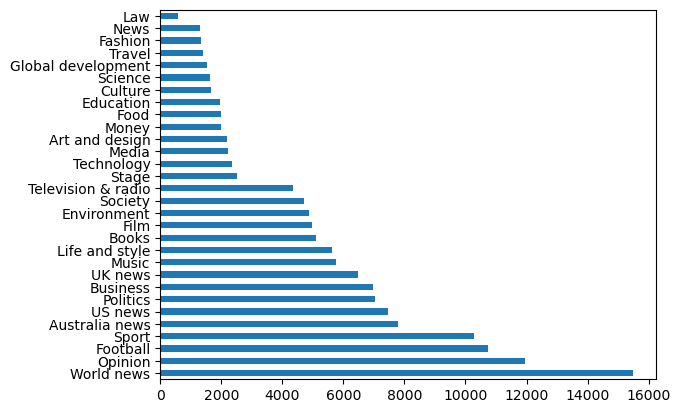

In [10]:
df['sectionName'].value_counts()[:30].plot(kind='barh')

## 2. Pre-Processing <a class="anchor" id="pre-bullet"></a>

[TOP ↑](#top)

In pre-processing, we must convert the raw data into a form which we can feed into a deep network. This will require the input and label data to be transformed into NumPy arrays. In general, pre-processing will require feature reduction, data transformation, target variable extraction, undersampling, label encoding, data partitioning, and text embedding.

### i. Feature Reduction <a class="anchor" id="a-bullet"></a>

[TOP ↑](#top)

First, since we're only interested in the text of the articles, the title, and the section name, we'll drop all columns apart from *bodyContent*, *webTitle*, and *sectionName*.

In [11]:
df = df.drop(["article_id", "webUrl", "webPublicationDate", "id"], axis='columns')

In [12]:
df.head()

,sectionName,webTitle,bodyContent
138546,Australia news,NSW government has ‘always known’ Covid deaths...,"The New South Wales premier, Dominic Perrottet..."
88013,Society,Helping parents choose vaccination for their c...,I am not sure that making immunisations compul...
14885,Sport,It is hard to get excited about a question mar...,"This is a story that starts, in a manner of sp..."
139824,Australia news,Grace Tame and Scott Morrison’s frosty meeting...,Pictures capturing an apparently frosty moment...
92431,Money,Tesco recalls Heinz baby food jars after metal...,Tesco has recalled thousands of jars of Heinz ...


### ii. Number of Labels and Data Quality <a class="anchor" id="b-bullet"></a>

[TOP ↑](#top)

Now, for data quality reasons, we'll drop any duplicated records that might be present in the dataset.

In [13]:
print(len(df))

148731


In [14]:
df = df.drop_duplicates()
print(len(df))

148494


Importantly, we must set a minumum number of records to ensure that, for each label in the dataset, there are a sufficient number of examples for training to take place. This will be especially important when balancing the dataset. We'll include only those sections which have a minumum number of examples, which we can decide here by setting the ```min_number_records```.

In [15]:
min_number_records = 10000

We can count the number of labels in the dataset and remove those records which come from a section with too few examples, less than the number chosen above.

In [16]:
# Count the frequency of each label in the DataFrame
label_counts = df['sectionName'].value_counts()

# Select labels that appear less than the requisite number of times
less_than_two = label_counts[label_counts <= min_number_records]

# Get the indices of records that contain the selected labels
indices_to_drop = df[df['sectionName'].isin(less_than_two.index)].index

# Remove records with the selected indices
df = df.drop(indices_to_drop)

Let's also print the number of unique labels present after processing.

In [17]:
unique_labels = df['sectionName'].nunique()
print(f"The number of unique labels in the dataset is:", unique_labels)

The number of unique labels in the dataset is: 4


### iii. Remove Stop Words and Lemmatisation <a class="anchor" id="c-bullet"></a>

[TOP ↑](#top)

Next, since we're merely classifying the articles, and not conducting a more nuanced interrogation of the text, such as sentiment analysis, we can remove stop words and perform lemmatisation in order to improve the efficiency and accuracy of the modelling.

In [18]:
#nltk.download('wordnet')
# Set the English stop words
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
# Create a function to turn all the text to lower case, and perform tokenisation and lemmatisation
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text
# Create a new column with the cleaned text, let's simply call it content
df['content'] = df['bodyContent'].apply(lambda x: clean_text(x))

In [19]:
# Create a new column with the cleaned text, let's simply call it title_content
df['title_content'] = df['webTitle'].apply(lambda x: clean_text(x))

We can print the head to verify that the processing worked and that the new columns were created.

In [20]:
df.head()

,sectionName,webTitle,bodyContent,content,title_content
14885,Sport,It is hard to get excited about a question mar...,"This is a story that starts, in a manner of sp...",story start manner speak astonish score spree ...,hard get excite question mark hide undisclosed...
60175,Sport,Saracens have the look of champions and Bristo...,Bath Director of rugby Todd Blackadder Perhaps...,bath director rugby todd blackadder perhaps ey...,saracen look champion bristol make mark
124370,Football,From Pirlo to no-go: what happened to New York...,New York has always been Major League Soccer’s...,new york ha always major league soccer toughes...,pirlo nogo happen new york era foreign ml mega...
68340,Opinion,You can’t escape Christmas – not even with a C...,"Can you ever truly escape Christmas? In 2007, ...",ever truly escape christmas 2007 discover cann...,cant escape christmas even caribbean holiday ...
85817,Opinion,Johnson’s plan is to turn his supreme court hu...,An angry and disturbingly pumped-up Boris John...,angry disturbingly pumpedup boris johnson resp...,johnson plan turn supreme court humiliation ro...


Finally, we can concatenate the two article title and the article content into a combined *concatenated* column.

In [21]:
df['concatenated'] = df['title_content'] + ' ' + df['content']

In [22]:
df.head()

,sectionName,webTitle,bodyContent,content,title_content,concatenated
14885,Sport,It is hard to get excited about a question mar...,"This is a story that starts, in a manner of sp...",story start manner speak astonish score spree ...,hard get excite question mark hide undisclosed...,hard get excite question mark hide undisclosed...
60175,Sport,Saracens have the look of champions and Bristo...,Bath Director of rugby Todd Blackadder Perhaps...,bath director rugby todd blackadder perhaps ey...,saracen look champion bristol make mark,saracen look champion bristol make mark bath d...
124370,Football,From Pirlo to no-go: what happened to New York...,New York has always been Major League Soccer’s...,new york ha always major league soccer toughes...,pirlo nogo happen new york era foreign ml mega...,pirlo nogo happen new york era foreign ml mega...
68340,Opinion,You can’t escape Christmas – not even with a C...,"Can you ever truly escape Christmas? In 2007, ...",ever truly escape christmas 2007 discover cann...,cant escape christmas even caribbean holiday ...,cant escape christmas even caribbean holiday ...
85817,Opinion,Johnson’s plan is to turn his supreme court hu...,An angry and disturbingly pumped-up Boris John...,angry disturbingly pumpedup boris johnson resp...,johnson plan turn supreme court humiliation ro...,johnson plan turn supreme court humiliation ro...


### iv. Target Variable Extraction <a class="anchor" id="d-bullet"></a>

[TOP ↑](#top)

We need to separate our dataframe into input (**X**) and label (**y**) data in the form of a matrix and vector for inclusion in the neural network model.

First, we'll deal with the input data, setting **X** to be equivalent to our dataframe including only the content column.

In [23]:
# We'll just set X to be equivalent to the dataframe including only the content
X = df.drop(['sectionName', 'bodyContent', 'webTitle', 'content', 'title_content'], axis=1)

In [24]:
# Print the shape of X
print(X.shape)

(48425, 1)


In [25]:
# Print the type of X, which should be a dataframe
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [26]:
print(X)

                                             concatenated
14885   hard get excite question mark hide undisclosed...
60175   saracen look champion bristol make mark bath d...
124370  pirlo nogo happen new york era foreign ml mega...
68340   cant escape christmas  even caribbean holiday ...
85817   johnson plan turn supreme court humiliation ro...
...                                                   ...
96173   gett israeli taxi app sue service use avoid ar...
47546   revolution take president club keep go  kj whi...
113223  mass covid19 test start england head tory revo...
18390   diy doctor new zealand medical student operate...
119743  brexit spain deny report round deport briton w...

[48425 rows x 1 columns]


In [27]:
X.head()

,concatenated
14885,hard get excite question mark hide undisclosed...
60175,saracen look champion bristol make mark bath d...
124370,pirlo nogo happen new york era foreign ml mega...
68340,cant escape christmas even caribbean holiday ...
85817,johnson plan turn supreme court humiliation ro...


Next, we'll deal with the label data, setting **y** to be a series with only the section name.

In [28]:
# We'll set y to be the vector of labels
y = df['sectionName']

In [29]:
# Print the shape of y
print(y.shape)

(48425,)


In [30]:
# Print the type of y, which should be a series
print(type(y))

<class 'pandas.core.series.Series'>


In [31]:
print(y)

14885          Sport
60175          Sport
124370      Football
68340        Opinion
85817        Opinion
             ...    
96173     World news
47546        Opinion
113223    World news
18390     World news
119743    World news
Name: sectionName, Length: 48425, dtype: object


### v. Undersampling the Data <a class="anchor" id="e-bullet"></a>

[TOP ↑](#top)

Since there is a significant class imbalance problem in this dataset, this will need to be remedied somehow. I experimented with using class weights (from sklearn) during training, but achieved better results by undersampling. Undersampling also helped to solve another problem: the large size of the dataset. With undersampling, we still retain a sufficient number of examples to achieve high accuracy but reduce the overall computation time.

The ```fit_resample``` method from the ```RandomUnderSampler``` class fits the under-sampler to the input data and then performs under-sampling to produce a new set of balanced data.

In [32]:
# Create an instance of the RandomUnderSampler class
rus = RandomUnderSampler(random_state=38)

# Undersample the dataset
X, y = rus.fit_resample(X, y)

We can quickly print the labels alongside the number of examples in the data for each one. These should be the same.

In [33]:
# Get the unique elements and their counts
unique_elements, counts = np.unique(y, return_counts=True)

# Sort the counts in descending order and get the top 15
sort_indices = np.argsort(-counts)
top_elements = unique_elements[sort_indices][:30]
top_counts = counts[sort_indices][:30]

print(top_elements, top_counts)

['Football' 'Opinion' 'Sport' 'World news'] [10266 10266 10266 10266]


### vi. Initial Label Encoding <a class="anchor" id="f-bullet"></a>

[TOP ↑](#top)

Next, we're going to re-encode the target labels from strings to integers, using ```LabelEncoder()``` from the Scikit-Learn library, which will also output the **y** series as a 1-D NumPy array. 

In [34]:
# Initialise the label encoder
le = LabelEncoder()

# Fit the label encoder to the data and transform the data
y = le.fit_transform(y)

In [35]:
# Get the labels and their encoded values
labels = le.classes_
values = le.transform(labels)

# Print the labels and their encoded values
print("Unique labels:", labels)
print("Encoded values:", values)

Unique labels: ['Football' 'Opinion' 'Sport' 'World news']
Encoded values: [0 1 2 3]


In [36]:
print(y.shape)

(41064,)


In [37]:
# Now, y should be a NumPy array
print(type(y))

<class 'numpy.ndarray'>


In [38]:
print(y)

[0 0 0 ... 3 3 3]


### vii. Data Partitioning <a class="anchor" id="g-bullet"></a>

[TOP ↑](#top)

Next, we need to split our data into training (81%), validation (10%), and test sets (9%). I'd also like to ensure that the partitioning of the data is done via stratified sampling, in order to preserve the underlying label distribution.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [40]:
print(f"The length of X_train is:", len(X_train))
print(f"The length of X_val is:", len(X_val))
print(f"The length of X_test is:", len(X_test))

The length of X_train is: 33261
The length of X_val is: 3696
The length of X_test is: 4107


In [41]:
print(f"The length of y_train is:", len(y_train))
print(f"The length of y_val is:", len(y_val))
print(f"The length of y_test is:", len(y_test))

The length of y_train is: 33261
The length of y_val is: 3696
The length of y_test is: 4107


In [42]:
unique_vals_ytrain = np.unique(y_train)
unique_vals_yval = np.unique(y_val)
unique_vals_ytest = np.unique(y_test)
print(f"The number of unique labels in the y_train set is:", len(unique_vals_ytrain))
print(f"The number of unique labels in the y_val set is:", len(unique_vals_yval))
print(f"The number of unique labels in the y_test set is:", len(unique_vals_ytest))

The number of unique labels in the y_train set is: 4
The number of unique labels in the y_val set is: 4
The number of unique labels in the y_test set is: 4


In [43]:
num_labels = len(unique_vals_ytrain)
print(f"The number of output labels is: {num_labels}")

The number of output labels is: 4


In [44]:
X_train_shape = X_train.shape
y_train_shape = y_train.shape
X_length = len(X)
y_length = len(y)
print("The X input shape is:", X_train_shape)
print("The y label shape is:", y_train_shape)
check_lengths = X_length == y_length
print(f"The length of the X and y arrays are the same: {check_lengths}")

The X input shape is: (33261, 1)
The y label shape is: (33261,)
The length of the X and y arrays are the same: True


In [45]:
# We can print the types again, expecting a DataFrame and a NumPy array
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [46]:
# I'm copying the original input data, prior to performing text embedding, for use later on
X_train_original_data = X_train.copy()
X_val_original_data = X_val.copy()
X_test_original_data = X_test.copy()

### vii. Text Embedding <a class="anchor" id="h-bullet"></a>

[TOP ↑](#top)

Next, we need to perform the text embedding in order to convert the text content of the articles to numerical form, for feeding into the deep network.

The ```maxlen``` parameter determines the maximum length of the input sequence, i.e. the number of words or tokens in each input text. Sequences that are shorter than this length will be padded with zeros, and sequences that are longer than this length will be truncated. It is a way of enforcing a fixed input size for the model. The ```max_features``` parameter determines the maximum number of unique words or tokens to be considered in the model's vocabulary. Words that appear less frequently than the top most common words will be replaced with an out-of-vocabulary token. It is a way of limiting the size of the embedding layer's weight matrix, which can speed up training and reduce overfitting. The ```embedding_size``` parameter determines the dimensionality of the embedding space, the size of the vector representation of each word in the vocabulary. A larger embedding size can capture more information about each word, but it requires more training data and can slow down training.

In [47]:
# Here, we set the hyperparameters
maxlen = 250
max_features = 1500
embedding_size = 8

In [48]:
# Create a tokenizer, which will remove punctuation and convert to lower case
tokenizer = Tokenizer(num_words=max_features, filters='–!"#$”%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)

First, we fit the tokenizer on the training data, then convert the training, validation, and test datasets to sequences of integer values based on this fitting.

**Training Data**

First, we must convert the values in the training dataframe to a NumPy array.

In [49]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [50]:
X_train = X_train['concatenated'].values

In [51]:
print(type(X_train))

<class 'numpy.ndarray'>


In [52]:
print(X_train)

['scar intrusive menace facial recognition  john naughton 18 july house common select committee science technology publish assessment work biometrics commissioner forensic science regulator guess citizen never hear two public servant pity important maintenance justice protection liberty human right current biometrics commissioner prof paul wile role keep review retention use police biometric material use dna sample custody image digital technology promise increase workload significantly seven year observe common committee since 2012 high court rule indefinite retention innocent people custody image wa unlawful yet practice continue system wa mean put place custody image keep six year review custody image unconvicted individual point weed delete havent photograph innocent people remain police national database doe matter basically image form basis watchlists automatic facialrecognition technology use police force public space ten year ago might much concern explosive growth realtime fac

In [53]:
# There were still some non-words present in the data, so I decided to run the text through another cleaning function

def remove_non_words(arr):
    
    cleaned_arr = np.empty_like(arr)

    for i, s in np.ndenumerate(arr):
        # Remove anything that isn't a regular English word
        cleaned_str = re.sub(r'[^\w\s]', '', s)
        cleaned_arr[i] = cleaned_str

    return cleaned_arr

In [54]:
X_train = remove_non_words(X_train)

In [55]:
print(X_train)

['scar intrusive menace facial recognition  john naughton 18 july house common select committee science technology publish assessment work biometrics commissioner forensic science regulator guess citizen never hear two public servant pity important maintenance justice protection liberty human right current biometrics commissioner prof paul wile role keep review retention use police biometric material use dna sample custody image digital technology promise increase workload significantly seven year observe common committee since 2012 high court rule indefinite retention innocent people custody image wa unlawful yet practice continue system wa mean put place custody image keep six year review custody image unconvicted individual point weed delete havent photograph innocent people remain police national database doe matter basically image form basis watchlists automatic facialrecognition technology use police force public space ten year ago might much concern explosive growth realtime fac

In [56]:
print(X_train.ndim)

1


In [57]:
print(X_train[0])

scar intrusive menace facial recognition  john naughton 18 july house common select committee science technology publish assessment work biometrics commissioner forensic science regulator guess citizen never hear two public servant pity important maintenance justice protection liberty human right current biometrics commissioner prof paul wile role keep review retention use police biometric material use dna sample custody image digital technology promise increase workload significantly seven year observe common committee since 2012 high court rule indefinite retention innocent people custody image wa unlawful yet practice continue system wa mean put place custody image keep six year review custody image unconvicted individual point weed delete havent photograph innocent people remain police national database doe matter basically image form basis watchlists automatic facialrecognition technology use police force public space ten year ago might much concern explosive growth realtime facia

Now, we can fit the tokenizer on the training data, and then perform the conversion.

In [58]:
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

In [59]:
# Convert the text data to sequences of word indices
X_train = tokenizer.texts_to_sequences(X_train)

In [60]:
# Take a quick look at the first result, which should be a list of integers
print(X_train[:1])

[[572, 877, 917, 277, 756, 880, 1423, 1439, 820, 32, 1423, 981, 103, 395, 19, 104, 297, 741, 1259, 339, 50, 526, 827, 399, 122, 937, 68, 187, 68, 1144, 1439, 540, 375, 425, 9, 756, 880, 59, 1196, 286, 290, 220, 10, 1144, 1, 106, 1094, 175, 257, 1, 118, 98, 82, 1144, 122, 179, 9, 937, 1144, 679, 66, 1272, 10, 128, 187, 129, 189, 410, 1144, 250, 1439, 68, 187, 147, 104, 654, 9, 213, 110, 58, 340, 1490, 1439, 526, 120, 187, 530, 118, 26, 163, 69, 22, 544, 69, 363, 507, 147, 1302, 162, 829, 1439, 104, 692, 756, 114, 3, 300, 374, 520, 1059, 486, 68, 2, 75, 700, 829, 197, 44, 186, 124, 1125, 1264, 225, 2, 69, 1439, 1144, 330, 1205, 99, 494, 1012, 1144, 294, 217, 1439, 2, 26, 26, 180, 258, 338, 1109, 316, 1027, 459, 102, 68, 781, 324, 1027, 643, 1055, 1261, 316, 41, 1245, 41, 240, 284, 187, 147, 41, 200, 330, 512, 275, 1313, 1307, 186, 225, 4, 1439, 600, 1439, 68, 538, 104, 835, 429, 571, 1010, 68, 377, 538, 1070, 104, 654, 550, 3, 10, 797, 116, 8, 438, 117, 264, 839, 331, 1074, 1336, 652, 26

In [61]:
# Take a quick look at the first result, which should be a list of integers
print(X_train[0])

[572, 877, 917, 277, 756, 880, 1423, 1439, 820, 32, 1423, 981, 103, 395, 19, 104, 297, 741, 1259, 339, 50, 526, 827, 399, 122, 937, 68, 187, 68, 1144, 1439, 540, 375, 425, 9, 756, 880, 59, 1196, 286, 290, 220, 10, 1144, 1, 106, 1094, 175, 257, 1, 118, 98, 82, 1144, 122, 179, 9, 937, 1144, 679, 66, 1272, 10, 128, 187, 129, 189, 410, 1144, 250, 1439, 68, 187, 147, 104, 654, 9, 213, 110, 58, 340, 1490, 1439, 526, 120, 187, 530, 118, 26, 163, 69, 22, 544, 69, 363, 507, 147, 1302, 162, 829, 1439, 104, 692, 756, 114, 3, 300, 374, 520, 1059, 486, 68, 2, 75, 700, 829, 197, 44, 186, 124, 1125, 1264, 225, 2, 69, 1439, 1144, 330, 1205, 99, 494, 1012, 1144, 294, 217, 1439, 2, 26, 26, 180, 258, 338, 1109, 316, 1027, 459, 102, 68, 781, 324, 1027, 643, 1055, 1261, 316, 41, 1245, 41, 240, 284, 187, 147, 41, 200, 330, 512, 275, 1313, 1307, 186, 225, 4, 1439, 600, 1439, 68, 538, 104, 835, 429, 571, 1010, 68, 377, 538, 1070, 104, 654, 550, 3, 10, 797, 116, 8, 438, 117, 264, 839, 331, 1074, 1336, 652, 263

Now, we print the top 20 words which occur, to get an idea of the content.

In [62]:
# Get the word frequency counts
word_counts = tokenizer.word_counts

# Sort the dictionary by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Print out the top 20 most frequent words
for word, count in sorted_words[:20]:
    print(word, count)

wa 211889
ha 134372
say 96078
one 72514
would 63537
make 59739
go 58021
time 55903
year 55768
people 55529
get 50947
take 49553
first 45958
last 44445
new 41633
come 41208
also 40578
win 39885
two 39873
like 39751


Now, we need to pad the sequences using the maximum length assigned earlier.

In [63]:
# Pad the sequences to have the same length
X_train = pad_sequences(X_train, maxlen=maxlen)

In [64]:
print(X_train.shape)

(33261, 250)


In [65]:
print(X_train[0].ndim)
print(X_train.ndim)

1
2


In [66]:
print(X_train[0])

[ 756  880   59 1196  286  290  220   10 1144    1  106 1094  175  257
    1  118   98   82 1144  122  179    9  937 1144  679   66 1272   10
  128  187  129  189  410 1144  250 1439   68  187  147  104  654    9
  213  110   58  340 1490 1439  526  120  187  530  118   26  163   69
   22  544   69  363  507  147 1302  162  829 1439  104  692  756  114
    3  300  374  520 1059  486   68    2   75  700  829  197   44  186
  124 1125 1264  225    2   69 1439 1144  330 1205   99  494 1012 1144
  294  217 1439    2   26   26  180  258  338 1109  316 1027  459  102
   68  781  324 1027  643 1055 1261  316   41 1245   41  240  284  187
  147   41  200  330  512  275 1313 1307  186  225    4 1439  600 1439
   68  538  104  835  429  571 1010   68  377  538 1070  104  654  550
    3   10  797  116    8  438  117  264  839  331 1074 1336  652  263
  151  102 1423   26  367   32   96   28  376   26    2   74   10 1439
  319   75  477   41   19  894  324 1439    4  927   20  477   68  927
   20 

**Validation and Test Data**

Now, we need to perform the same processing steps for the validation and test datasets.

In [67]:
# Transform from a DF to NumPy array
X_val = X_val['concatenated'].apply(lambda x: x.lower()).values

# Convert the validation data to sequences of integer values
X_val = tokenizer.texts_to_sequences(X_val)

# Pad the validation sequences
X_val = pad_sequences(X_val, maxlen=maxlen)

In [68]:
# Transform from a DF to NumPy array
X_test = X_test['concatenated'].apply(lambda x: x.lower()).values

# Convert the test data to sequences of integer values
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the test sequences
X_test = pad_sequences(X_test, maxlen=maxlen)

### viii. One-Hot Encoding <a class="anchor" id="i-bullet"></a>

[TOP ↑](#top)

The final step in pre-processing the data will be to perform one-hot encoding on the target label data.

In [69]:
# Since the label datasets are arrays of integers representing the labels, we can now perform one-hot encoding
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val, num_classes=y_train_onehot.shape[1])
y_test_onehot = to_categorical(y_test, num_classes=y_train_onehot.shape[1])

In [70]:
# We can print the shape of the data to verify if the encoding worked
print(y_train_onehot.shape)

(33261, 4)


In [71]:
# We can also print the first example
print(y_train_onehot[0])

[0. 1. 0. 0.]


## 3. LSTM Models <a class="anchor" id="model2-bullet"></a>

[TOP ↑](#top)

In the next part of the project, we can experiment with different deep learning architectures. Ultimately, I settled on a combination of Convolutional Neural Network (CNN) and Long Short Term Memory (LSTM) Model, which exhibited the best performance.

### i. CNN and LSTM Model <a class="anchor" id="cnnlstmmodel-bullet"></a>

[TOP ↑](#top)

In this section, we build a model with an embedding layer, a Long Short Term Memory layer, a hidden layer with 350 neurons, and an output layer with a softmax activation function. Once again, we opt for a CategoricalCrossentropy loss function, the adam optimiser, and accuracy as our primary metric. In addition, we also employ dropout and early stopping to prevent overfitting. We ensure that the same state size is utilised in both the RNN and LSTM.

In [72]:
# Here, we define the hyperparameters
batch_size = 250
state_size = 8

In [73]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense

In [74]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, embedding_size))
lstm_model.add(Conv1D(256, 4, activation='relu'))
lstm_model.add(MaxPooling1D(5))
lstm_model.add(Dropout(0.25))
lstm_model.add(Conv1D(64, 10, activation='relu'))
lstm_model.add(MaxPooling1D(5))
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(350, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_labels, activation='softmax'))
lstm_model.summary()

Metal device set to: Apple M1


2023-05-08 11:19:30.804817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-08 11:19:30.806220: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           12000     
                                                                 
 conv1d (Conv1D)             (None, None, 256)         8448      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 256)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          163904    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                    

In [75]:
# Define the early stopping callback, and set the patience to three
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [76]:
lstm_model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [77]:
lstm_hist = lstm_model.fit(X_train, y_train_onehot,
          batch_size=32,
          epochs=20,
          validation_data=(X_val, y_val_onehot),
          callbacks=[early_stopping])

Epoch 1/20


2023-05-08 11:19:31.362201: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-08 11:19:32.275941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:19:32.587579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:19:32.688405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:19:32.855174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:19:32.978097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1040/1040 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.6945

2023-05-08 11:20:02.036727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:20:02.134825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:20:02.188346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1040/1040 [==============================] - 32s 29ms/step - loss: 0.6739 - accuracy: 0.6945 - val_loss: 0.3233 - val_accuracy: 0.8929
Epoch 2/20
1040/1040 [==============================] - 29s 28ms/step - loss: 0.2572 - accuracy: 0.9261 - val_loss: 0.2427 - val_accuracy: 0.9297
Epoch 3/20
1040/1040 [==============================] - 103s 99ms/step - loss: 0.2006 - accuracy: 0.9446 - val_loss: 0.2203 - val_accuracy: 0.9386
Epoch 4/20
1040/1040 [==============================] - 30s 29ms/step - loss: 0.1723 - accuracy: 0.9533 - val_loss: 0.2543 - val_accuracy: 0.9240
Epoch 5/20
1040/1040 [==============================] - 30s 29ms/step - loss: 0.1531 - accuracy: 0.9587 - val_loss: 0.2038 - val_accuracy: 0.9443
Epoch 6/20
1040/1040 [==============================] - 30s 29ms/step - loss: 0.1384 - accuracy: 0.9643 - val_loss: 0.2002 - val_accuracy: 0.9418
Epoch 7/20
1040/1040 [==============================] - 30s 29ms/step - loss: 0.1287 - accuracy: 0.9657 - val_loss: 0.2133 - val_accur

In [78]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test_onehot)
print(f"Test loss: {lstm_loss}")
print(f"Test accuracy: {lstm_accuracy}")

129/129 [==============================] - 2s 14ms/step - loss: 0.2219 - accuracy: 0.9389
Test loss: 0.22193478047847748
Test accuracy: 0.9388848543167114


In this case, we achieve a very high accuracy. It seems that the LSTM model is able to overcome the vanishing gradient problem.

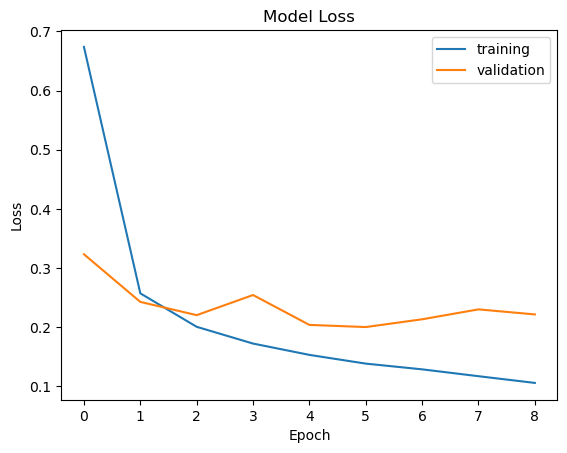

In [79]:
# Plot the training and validation loss
plt.plot(lstm_hist.history['loss'], label='training')
plt.plot(lstm_hist.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

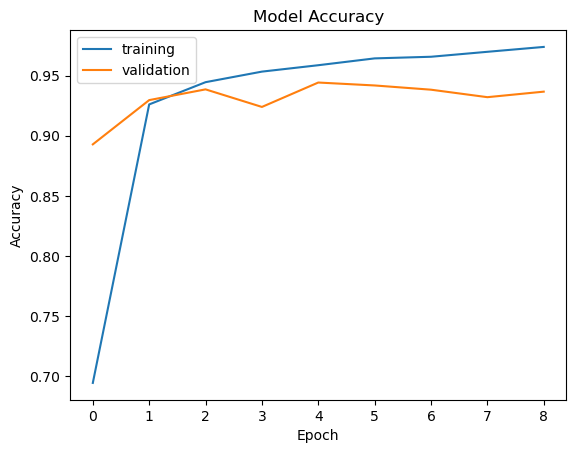

In [80]:
# Plot the training and validation accuracy
plt.plot(lstm_hist.history['accuracy'], label='training')
plt.plot(lstm_hist.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

2023-05-08 11:25:18.199210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:25:18.289857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 11:25:18.350860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 1s 7ms/step


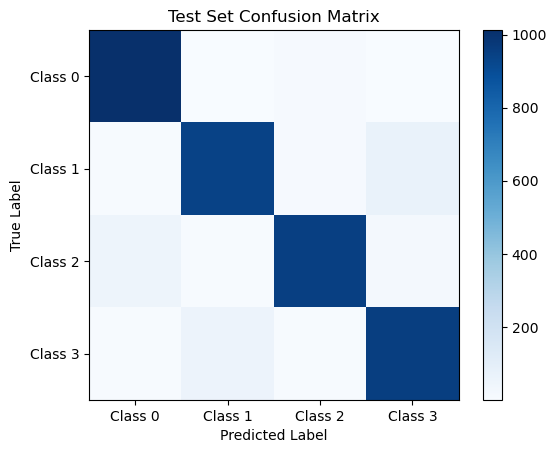

In [81]:
# Make predictions with your model on a validation set
y_pred = lstm_model.predict(X_test)

# Get the predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes
y_true = np.argmax(y_test_onehot, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Test Set Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# We need to create a dynamic list for the class labels, as these may change
ticks = list(range(unique_labels)) 
labels = ['Class {}'.format(i) for i in range(unique_labels)] 
plt.xticks(ticks, labels) 
plt.yticks(ticks, labels) 
plt.show()

In [82]:
print('Test Set Confusion Matrix:')
confusion_matrix(y_pred_classes, y_true)

Test Set Confusion Matrix:


array([[1012,    8,   49,    6],
       [   1,  938,    6,   59],
       [  11,   10,  952,    8],
       [   3,   70,   20,  954]])

Now, we can produce a Classification Report based on the validation data. This will give us the precision, recall, and F1 score for each of our classes. Precision is the proportion of true positive predictions out of all positive predictions made by the model. It measures how many of the predicted positive instances are actually positive. A high precision indicates that the model makes few false positive predictions. Recall is the proportion of true positive predictions out of all actual positive instances in the dataset. It measures how many of the actual positive instances were correctly identified by the model. A high recall indicates that the model makes few false negative predictions. Finally, the F1 score is the harmonic mean of precision and recall, and is a measure of overall accuracy that balances the importance of precision and recall. It ranges from 0 to 1, with a higher score indicating better performance.

In [83]:
# Make predictions with our validation data
y_pred = lstm_model.predict(X_test)

# Get the predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes
y_true = np.argmax(y_test_onehot, axis=1)

# Print the Classification Report
print(classification_report(y_true, y_pred_classes))

129/129 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1027
           1       0.93      0.91      0.92      1026
           2       0.97      0.93      0.95      1027
           3       0.91      0.93      0.92      1027

    accuracy                           0.94      4107
   macro avg       0.94      0.94      0.94      4107
weighted avg       0.94      0.94      0.94      4107



Finally, we can use our model on the test set to evaluate the model's performance on unseen data.

In [84]:
loss, accuracy = lstm_model.evaluate(X_test, y_test_onehot)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

129/129 [==============================] - 2s 14ms/step - loss: 0.2219 - accuracy: 0.9389
Test Loss: 0.22193478047847748
Test Accuracy: 0.9388848543167114


In [85]:
from tensorflow.keras.models import load_model

# Save the model
lstm_model.save('cnn_lstm_model.h5')

# Load the model
#loaded_model = load_model('my_model.h5')